In [1]:
import pandas as pd
from typing import List, Any, Dict, Union
from haystack import component
from haystack.dataclasses import ChatMessage
import re
import os
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.utils import Secret
from haystack.components.routers import ConditionalRouter

from haystack.components.joiners import BranchJoiner
import gradio as gr

import sqlite3

OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

import logging
logging.basicConfig(
    level=logging.INFO,  
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)



/Users/simonamazzarino/Documents/Progetti/talk_slides/2025_DevFest/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ConditionalOutputError(Exception):
    def __init__(self, message, details=None):
        super().__init__(message)
        self.details = details

In [3]:
@component
class SQLQuery:
    """
    Component to perform SQL queries on a SQLite database.
    Returns results as Pandas DataFrames.
    """

    def __init__(self, sql_database: str):
        self.sql_database = sql_database
        logger.info(f"SQLQuery initialized with database: {sql_database}")

    @component.output_types(results=Union[pd.DataFrame, List[pd.DataFrame]], queries=List[str])
    def run(self, queries: List[str]) -> Dict[str, Any]:
        # Normalize input into a list
        if isinstance(queries, str):
            queries = [queries]
        elif not isinstance(queries, list):
            queries = [str(queries)]

        logger.info(f"Received {len(queries)} query(ies) to execute")

        results = []
        processed_queries = []

        # Open SQLite connection
        try:
            connection = sqlite3.connect(self.sql_database)
            logger.debug("SQLite connection successfully established.")
        except Exception as e:
            logger.error(f"Failed to connect to SQLite database: {str(e)}")
            raise

        for query in queries:
            try:
                logger.info(f"Executing SQL query:\n{query}")
                df = pd.read_sql_query(query, connection)

                logger.info(f"Query executed successfully — {len(df)} row(s) retrieved.")
                results.append(df)
                processed_queries.append(query)

            except Exception as e:
                logger.error(f"Error executing SQL query '{query}': {str(e)}")
                logger.debug("Creating error DataFrame with exception message.")
                error_df = pd.DataFrame({"error": [str(e)]})
                results.append(error_df)
                processed_queries.append(query)

        # Close connection
        try:
            connection.close()
            logger.debug("SQLite connection closed.")
        except Exception as e:
            logger.warning(f"Error closing database connection: {str(e)}")

        # Determine output type
        if len(results) == 1:
            logger.info("Returning single query result.")
            return {"results": results[0], "queries": processed_queries}
        else:
            logger.info("Returning multiple query results.")
            return {"results": results, "queries": processed_queries}



In [4]:
@component
class PostProcessSQL:
    """
    Component to clean and sanitize LLM-generated SQL queries before execution.
    Removes markdown formatting, trims whitespace, and checks for basic syntax artifacts.
    """
    @component.output_types(cleaned_queries=List[str])
    def run(self, queries: List[str]):
        if isinstance(queries, str):
            queries = [queries]
        elif not isinstance(queries, list):
            queries = [str(queries)]

        cleaned_queries = []
        for query in queries:
            original = query

            # Remove markdown code fences
            query = re.sub(r"^```sql\s*|```$", "", query.strip(), flags=re.IGNORECASE | re.MULTILINE)

            # Strip surrounding whitespace and newlines
            query = query.strip()

            # Replace smart quotes with straight quotes
            query = query.replace("‘", "'").replace("’", "'").replace("“", '"').replace("”", '"')

            # Replace non-breaking spaces or invisible characters
            query = query.replace('\xa0', ' ')

            # Optional: Collapse multiple spaces into one
            query = re.sub(r'\s+', ' ', query)

            cleaned_queries.append(query)

            logger.debug(f"Original Query:\n{original}\nCleaned Query:\n{query}\n")

        return {"cleaned_queries": cleaned_queries}


In [5]:
@component
class ValidateSQLResults:
    """
    Component to validate and control the number of SQL result rows displayed.
    If the result contains more than `max_display_rows`, only the first N rows are shown along with a warning message.
    """
    def __init__(self, max_display_rows: int = 200):
        self.max_display_rows = max_display_rows

    @component.output_types(result=Any, warning=Union[str, None])
    def run(self, result: Union[pd.DataFrame, List[pd.DataFrame]]) -> Dict[str, Any]:
        # Ensure the result is a pandas DataFrame
        if not isinstance(result, pd.DataFrame):
            print(f"Result type: {type(result)}")
            print(f"Result content: {result}")
            raise ValueError("The provided result is not a Pandas DataFrame.")

        # Handle empty results
        if result.empty:
            warning = "No results found for the query."
            logger.warning(warning)
            return {"result": result, "warning": warning}

        # If there are more rows than allowed, return only the first N and issue a warning
        if len(result) > self.max_display_rows:
            warning = (
                f"The result contains {len(result)} rows. "
                f"Only the first {self.max_display_rows} will be displayed."
            )
            logger.warning(warning)
            result = result.head(self.max_display_rows)
        else:
            warning = None

        # Set Pandas display options
        pd.set_option("display.max_rows", self.max_display_rows)
        pd.set_option("display.max_columns", None)
        pd.set_option("display.width", None)
        pd.set_option("display.max_colwidth", None)

        logger.debug(f"Final result to display:\n{result}")

        return {"result": result, "warning": warning}


In [6]:
@component
class QueryCorrection:
    """
    Component that receives failed SQL queries and corresponding error messages,
    then uses an LLM to regenerate a corrected version of the query.
    It dynamically builds the prompt by including table structures
    and descriptions from SQLite and associated data dictionaries.
    """

    def __init__(self, openai_api_key: str, database_path: str, dictionary_folder_path: str):
        self.openai_api_key = openai_api_key
        self.database_path = database_path
        self.dictionary_folder_path = dictionary_folder_path

    def create_system_prompt(self, query: str, error: str) -> str:
        """
        Builds a system prompt including SQLite table schemas and data dictionaries
        to help the LLM correct the invalid SQL query.
        """

        try:
            connection = sqlite3.connect(self.database_path)
            cursor = connection.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [row[0] for row in cursor.fetchall()]
        except Exception as e:
            logger.error(f"Error listing SQLite tables: {e}")
            tables = []
        finally:
            connection.close()

        table_sections = []
        for table in tables:
            csv_path = os.path.join(self.dictionary_folder_path, f"{table}_description.csv")
            if not os.path.exists(csv_path):
                logger.warning(f"Data dictionary not found for table '{table}' at {csv_path}")
                continue

            try:
                connection = sqlite3.connect(self.database_path)
                cursor = connection.cursor()
                cursor.execute(f"PRAGMA table_info({table});")
                columns_info = cursor.fetchall()
                columns_str = ", ".join([col[1] for col in columns_info])  # col[1] = column name
            except Exception as e:
                logger.error(f"Error getting schema for table {table}: {e}")
                columns_str = "Schema not available"
            finally:
                connection.close()

            dict_df = pd.read_csv(csv_path)
            dictionary_entries = []
            for _, row in dict_df.iterrows():
                name = str(row["column_name"]) if "column_name" in row else "unknown"
                description = str(row["description"]) if "description" in row else ""
                entry = f"{name}: {description}"
                dictionary_entries.append(entry)
            data_dictionary_str = "\n".join(dictionary_entries)

            section = f"""
Table '{table}' with columns: {columns_str}.

Data dictionary for table '{table}':
{data_dictionary_str}
"""
            table_sections.append(section.strip())

        return f"""
You are an assistant that corrects SQL queries for a SQLite database.
Below are the available tables with their columns and data dictionaries:

{chr(10).join(table_sections)}

The query that caused the error:

{query}

The error message received:

{error}

Rewrite the SQL query by correcting the error while keeping the original intent.
Respond only with the corrected SQL query, without any explanations or comments.
"""

    @component.output_types(corrected_queries=List[str])
    def run(self, queries: List[str], error: List[str]) -> Dict[str, Any]:
        try:
            system_prompt = self.create_system_prompt(queries[0], error[0])
            prompt_template = [ChatMessage.from_system(system_prompt)]

            prompt = ChatPromptBuilder(
                template=prompt_template,
                variables=["queries", "error"],
                required_variables=["queries", "error"]
            )

            llm = OpenAIChatGenerator(model="gpt-4o-mini", api_key=Secret.from_token(self.openai_api_key))

            pipeline = Pipeline()
            pipeline.add_component("prompt", prompt)
            pipeline.add_component("llm", llm)
            pipeline.connect("prompt", "llm")

            logger.info(f"Running query correction for: {queries[0]} | Error: {error[0]}")
            results = pipeline.run(
                {"prompt": {"queries": queries[0], "error": error[0]}},
                include_outputs_from=["llm"]
            )

            corrected_query = [results["llm"]["replies"][0].text.strip()]
            logger.info("Query correction completed successfully.")
            logger.info(f"Corrected query: {corrected_query}")

            return {"corrected_queries": corrected_query}

        except Exception as e:
            logger.error(f"Error during query correction: {e}", exc_info=True)
            return {"corrected_queries": [f"Error during correction: {str(e)}"]}

        

@component
class ConditionalOutputComponent:
    """Component that checks for the 'errore' column and adjusts the output type accordingly."""

    @component.output_types(
        results=pd.DataFrame, error=List[str]
    )
    def run(self, results: Union[pd.DataFrame, List[pd.DataFrame]]) -> dict:
        if 'errore' not in results.columns:
            # If 'errore' column is absent, return as a DataFrame
            return {"results": results}
        else:
            # If 'errore' column is present, return as a list of strings
            return {"error": results['errore'].tolist()}

In [7]:
def create_system_prompt(database_path, dictionary_folder_path):
    """
    Generates a structured system prompt for an LLM, including table data dictionaries
    and a few-shot section with example queries and responses.

    Returns:
        list: A list containing a single ChatMessage object with the complete system prompt.
    """
    # Initial prompt
    start_prompt = """You are an intelligent assistant specialized in generating SQL queries 
for a SQLite database. The SQL query must answer the following question: {{question}}.
You have access to the conversation memory to help you answer the question. 
Conversation memory: {{memory}}.
You have access to a relational database composed of the following tables:"""

    # Connect to the database
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()

    # Retrieve table names in SQLite
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [row[0] for row in cursor.fetchall()]

    table_sections = []
    for table in tables:
        csv_path = os.path.join(dictionary_folder_path, f"{table}_description.csv")
        if not os.path.exists(csv_path):
            continue

        # Get column names and types from SQLite
        cursor.execute(f"PRAGMA table_info({table});")
        columns_info = cursor.fetchall()
        columns_str = ', '.join([col[1] for col in columns_info])  # col[1] = column name

        # Load the description CSV for this table
        dict_df = pd.read_csv(csv_path)
        dictionary_entries = []
        for _, row in dict_df.iterrows():
            name = str(row["column_name"]) if "column_name" in row else "unknown"
            description = str(row["description"]) if "description" in row else ""
            entry = f"{name}: {description}"
            dictionary_entries.append(entry)
        data_dictionary_str = "\n".join(dictionary_entries)

        section = f"""
Table '{table}' with columns: {columns_str}.

Data dictionary for table '{table}':
{data_dictionary_str}
"""
        table_sections.append(section.strip())

    connection.close()

    end_prompt = """
    - Use only real column names from the database, never invent or assume columns.
    - Output only the SQL query, with no markdown, comments, or explanations.
    - Use single quotes ' ' for strings. Escape apostrophes by doubling them.
    - Exclude NULLs with IS NOT NULL when relevant.
    - Use AND for main filters, OR for optional ones.
    - For numeric ranges, use BETWEEN (e.g., WHERE age BETWEEN 18 AND 65).
    - Always use LIMIT to restrict results.
    - Do not use backticks (`) or double quotes for identifiers.
    - Use LOWER() only on text columns, not numeric or boolean ones.
    - To find the most frequent value of a column (mode):

        SELECT 'column' AS variable, column AS value, COUNT(*) AS freq
        FROM table
        WHERE column IS NOT NULL
        GROUP BY column
        ORDER BY freq DESC
        LIMIT 1;
    - If combining queries with UNION or UNION ALL, use ORDER BY and LIMIT only once at the end.
    - When multiple blocks share the same filters or joins, use a CTE (WITH ... AS (...)).
    - When joining tables with shared id columns, prefix with the table name (e.g., users.id).
    - Avoid including id unless necessary.
    - When calculating ratios, use subqueries to divide filtered counts by group totals.
    - Do not alias columns in GROUP BY.
    - If AVG() is requested on a non-numeric column, return the mode instead.
    
    - Only create SQL queries relevant to the database; if not applicable, return exactly no_answer.
    - Generate only the SQL query."""
    # Return the constructed system prompt
    return [ChatMessage.from_system(start_prompt + "\n\n" + "\n\n".join(table_sections) + "\n\n" + end_prompt)]

In [8]:
database_path = 'database.db'
dictionary_folder_path = "data_dictionaries/"
system_prompt = create_system_prompt(database_path, dictionary_folder_path)
print(system_prompt[0].text)

You are an intelligent assistant specialized in generating SQL queries 
for a SQLite database. The SQL query must answer the following question: {{question}}.
You have access to the conversation memory to help you answer the question. 
Conversation memory: {{memory}}.
You have access to a relational database composed of the following tables:

Table 'country_and_continent_codes_list' with columns: Continent_Name, Continent_Code, Country_Name, Two_Letter_Country_Code, Three_Letter_Country_Code, Country_Number.

Data dictionary for table 'country_and_continent_codes_list':
Continent_Name: Full name of the continent (e.g., 'Europe', 'Asia', 'Africa').
Continent_Code: Short alphabetic code representing each continent (e.g., 'EU', 'AS', 'AF').
Country_Name: Official full name of the country (e.g., 'France', 'Japan', 'Brazil').
Two_Letter_Country_Code: ISO 3166-1 alpha-2 country code (e.g., 'FR' for France, 'JP' for Japan).
Three_Letter_Country_Code: ISO 3166-1 alpha-3 country code (e.g., 'FR

In [9]:
system_prompt_nl_answer = """You are an intelligent assistant that provides natural language answers based on data obtained through SQL queries.

You will receive four pieces of information:
1. User question: a request written in natural language.
2. SQL query used: the query executed to obtain the data.
3. Query result: the data retrieved from the database (in tabular or structured text form).
4. Warning: a warning message that may appear if the result has more rows than allowed or if no results were found.

Your task is to:
- Correctly interpret the meaning of the result.
- Connect the result to the original question.
- Return an answer in clear, well-formulated natural English. 
- If the query result contains tabular data, present it as a clean Markdown table with headers. 
- Do not use JSON or code blocks. Keep the answer concise and in natural language below the table.
- Do not explain the SQL query; focus on the meaning of the data.
- If a value in the table is 'NaN', replace it with 'null'.
- If the pipeline generated an error because some data are unavailable or missing, never mention the dataset structure in the response. In particular, do not list existing columns or explicitly say that a column is missing.



User question:
{{ question }}

SQL query used:
{{ query }}

Query result:
{{ result }}

Warning:
{{ warning }}

"""

system_prompt_nl_answer = [ChatMessage.from_system(system_prompt_nl_answer)]


In [10]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{replies[0].text}}",
        "output_name": "answer", 
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0].text}}",
        "output_name": "query",
        "output_type": List[str],
    },
]

In [11]:
routes

[{'condition': "{{'no_answer' in replies[0]|lower}}",
  'output': '{{replies[0].text}}',
  'output_name': 'answer',
  'output_type': str},
 {'condition': "{{'no_answer' not in replies[0]|lower}}",
  'output': '{{replies[0].text}}',
  'output_name': 'query',
  'output_type': typing.List[str]}]

In [12]:
def get_sql_pipeline(dictionary_folder_path: str, openai_api_key: str):
    """
    Build and initialize the SQL query generation and validation pipeline for SQLite.

    The pipeline:
    - Converts natural language questions into SQL queries.
    - Executes queries against a SQLite database.
    - Validates and limits result size.
    - Corrects invalid SQL queries using the QueryCorrection component.
    - Generates a natural language explanation of the final result.

    Args:
        dictionary_folder_path (str): Path to the folder containing table data dictionaries.
        openai_api_key (str): API key for OpenAI models.

    Returns:
        Pipeline: A fully configured SQL pipeline instance.
    """
    # Optional fallback key (you can remove if not needed)
    try:
        logger.info("Initializing SQL pipeline with SQLite configuration")

        # === 1. System prompt creation ===
        logger.info("Creating system prompt for SQL generation")
        system_prompt = create_system_prompt(
            database_path="database.db",
            dictionary_folder_path=dictionary_folder_path
        )

        logger.info("Building ChatPromptBuilder components")
        prompt = ChatPromptBuilder(
            template=system_prompt,
            variables=["question", "memory"],
            required_variables=["question", "memory"]
        )
        nl_answer_prompt = ChatPromptBuilder(
            template=system_prompt_nl_answer,
            variables=["question", "query", "result", "warning"],
            required_variables=["question", "query", "result", "warning"]
        )

        # === 2. LLM setup ===
        logger.info("Initializing LLM components")
        llm = OpenAIChatGenerator(model="gpt-4.1", api_key=Secret.from_token(openai_api_key))
        nl_answer_llm = OpenAIChatGenerator(model="gpt-4o-mini", api_key=Secret.from_token(openai_api_key))

        # === 3. Pipeline components ===
        logger.info("Setting up SQL and control components")
        sql_query = SQLQuery("database.db")                 # SQLite database
        post_processor = PostProcessSQL()                   # Clean LLM SQL output
        result_validator = ValidateSQLResults(max_display_rows=50)
        router = ConditionalRouter(routes=routes)
        branch_joiner = BranchJoiner(List[str])
        conditional_output = ConditionalOutputComponent()
        query_correction = QueryCorrection(
            openai_api_key=openai_api_key,
            database_path="database.db",
            dictionary_folder_path=dictionary_folder_path
        )

        # === 4. Pipeline assembly ===
        sql_pipeline = Pipeline(max_runs_per_component=5)

        logger.info("Adding components to the pipeline")
        sql_pipeline.add_component("prompt", prompt)
        sql_pipeline.add_component("llm", llm)
        sql_pipeline.add_component("router", router)
        sql_pipeline.add_component("branch_joiner", branch_joiner)
        sql_pipeline.add_component("post_processor", post_processor)
        sql_pipeline.add_component("sql_querier", sql_query)
        sql_pipeline.add_component("conditional_output", conditional_output)
        sql_pipeline.add_component("query_correction", query_correction)
        sql_pipeline.add_component("result_validator", result_validator)
        sql_pipeline.add_component("nl_answer_prompt", nl_answer_prompt)
        sql_pipeline.add_component("nl_answer_llm", nl_answer_llm)

        # === 5. Component connections ===
        logger.info("Connecting components in the pipeline")

        # Natural language → SQL generation
        sql_pipeline.connect("prompt", "llm")
        sql_pipeline.connect("llm.replies", "router.replies")
        sql_pipeline.connect("router.query", "branch_joiner")
        sql_pipeline.connect("branch_joiner", "post_processor.queries")
        sql_pipeline.connect("post_processor.cleaned_queries", "sql_querier.queries")

        # SQL execution & correction
        sql_pipeline.connect("sql_querier.results", "conditional_output.results")
        sql_pipeline.connect("conditional_output.error", "query_correction.error")
        sql_pipeline.connect("sql_querier.queries", "query_correction.queries")
        sql_pipeline.connect("query_correction.corrected_queries", "branch_joiner")

        # Validation and natural language explanation
        sql_pipeline.connect("conditional_output.results", "result_validator.result")
        sql_pipeline.connect("sql_querier.queries", "nl_answer_prompt.query")
        sql_pipeline.connect("result_validator.result", "nl_answer_prompt.result")
        sql_pipeline.connect("result_validator.warning", "nl_answer_prompt.warning")
        sql_pipeline.connect("nl_answer_prompt", "nl_answer_llm")

        logger.info("SQL pipeline for SQLite initialized successfully")
        return sql_pipeline

    except Exception as e:
        logger.error(f"Error initializing SQL pipeline: {e}")
        raise



11:10:20 - INFO - __main__ - Initializing SQL pipeline with SQLite configuration
11:10:20 - INFO - __main__ - Creating system prompt for SQL generation
11:10:20 - INFO - __main__ - Building ChatPromptBuilder components
11:10:20 - INFO - __main__ - Initializing LLM components
11:10:20 - INFO - __main__ - Setting up SQL and control components
11:10:20 - INFO - __main__ - SQLQuery initialized with database: database.db
11:10:20 - INFO - __main__ - Adding components to the pipeline
11:10:20 - INFO - __main__ - Connecting components in the pipeline
11:10:20 - INFO - __main__ - SQL pipeline for SQLite initialized successfully


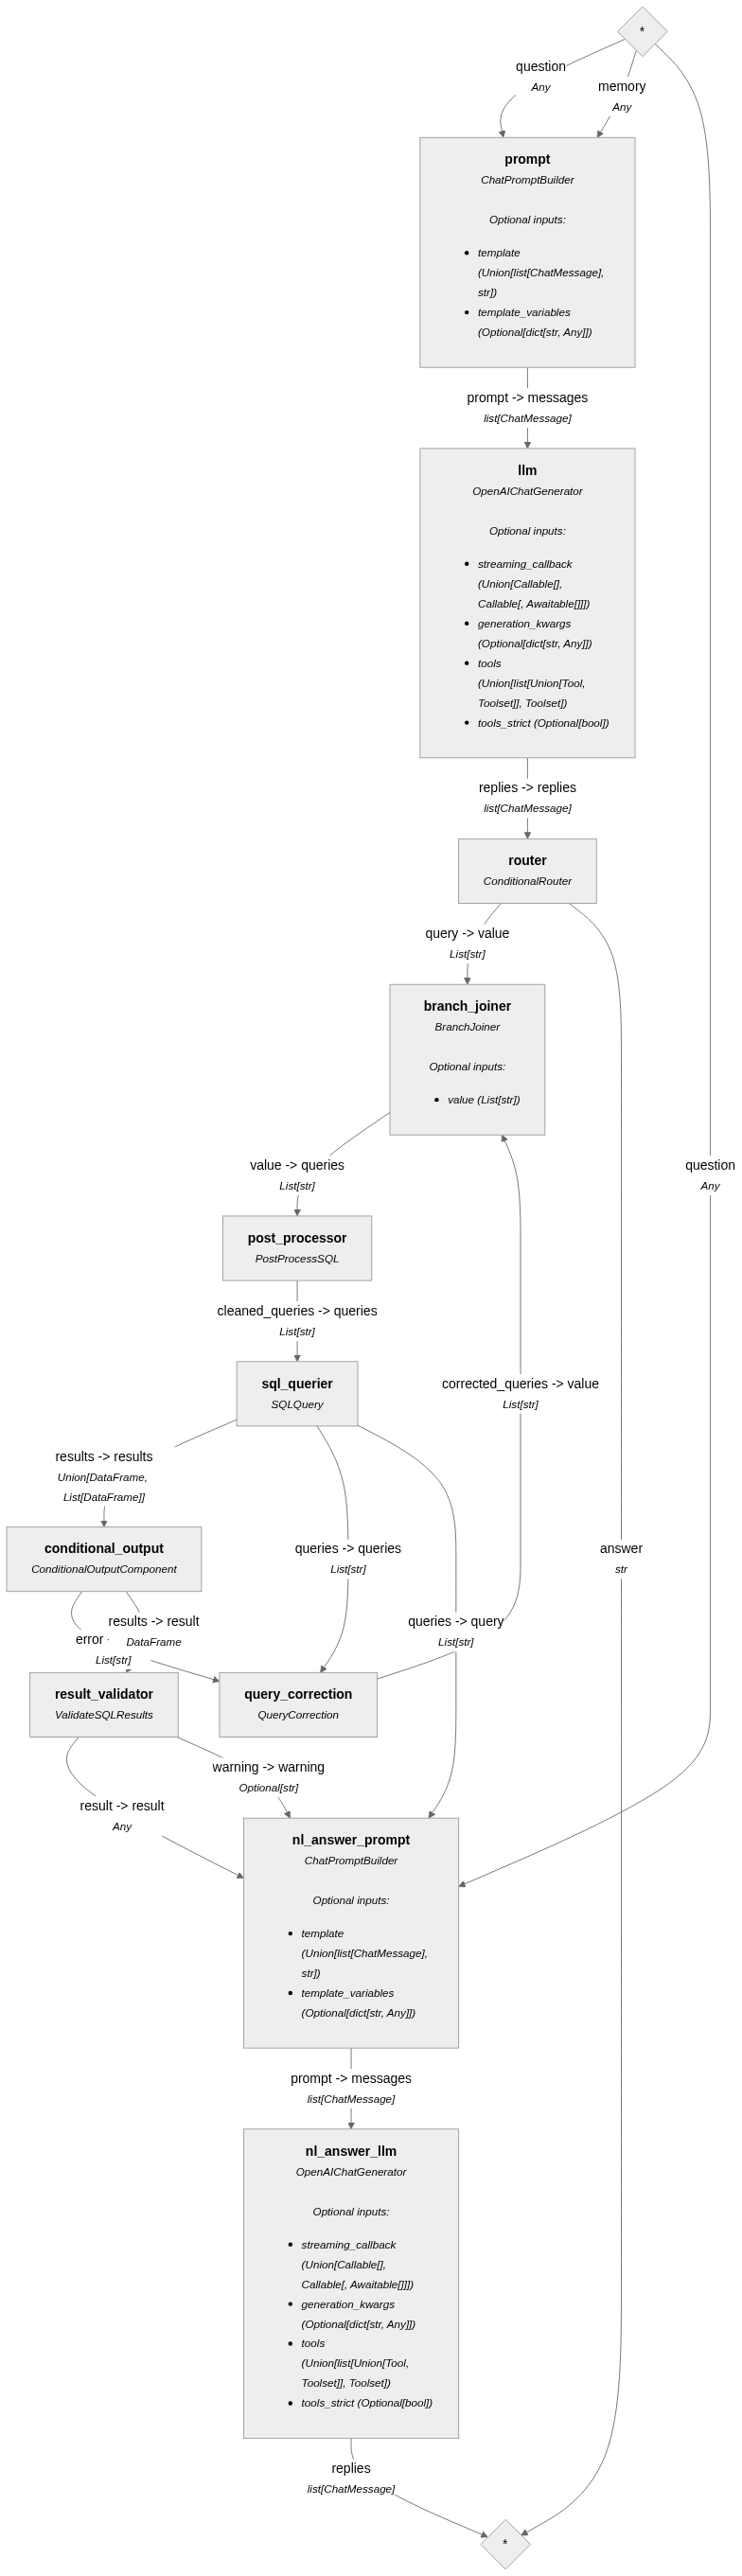

In [13]:
sql_pipeline = get_sql_pipeline(dictionary_folder_path="data_dictionaries/", openai_api_key=OPENAI_API_TOKEN)
sql_pipeline.show()

In [ ]:
def chat_sql_agent(user_query, history):
    """
    Chat handler for the Gradio interface.
    Simulates your while-loop chat interaction.
    """
    if not user_query.strip():
        return history, history  # No empty inputs

    # Handle exit keywords
    if user_query.lower() in ["exit", "quit"]:
        history.append(("System", "Session ended. Goodbye!"))
        return "", history

    # Prepare messages memory
    messages = [ChatMessage.from_user(msg[0]) for msg in history if isinstance(msg, tuple)]
    messages.append(ChatMessage.from_user(user_query))

    # Run the SQL pipeline
    result = sql_pipeline.run(
        {
            "prompt": {"question": ChatMessage.from_user(user_query), "memory": messages},
            "nl_answer_prompt": {"question": ChatMessage.from_user(user_query)},
        },
        include_outputs_from=[
            "prompt", "llm", "sql_querier", "post_processor", "nl_answer_llm", "router", "nl_answer_prompt"
        ]
    )

    # Handle no_answer responses
    if "no_answer" in result["llm"]["replies"][0].text.lower():
        response_text = "❌ It's impossible to answer the question because it is not relevant to the database."
        print(f"[red]{response_text}[/red]")
    else:
        response_text = result["nl_answer_llm"]["replies"][0].text
        print(f"[green]{response_text}[/green]")

    # Update conversation history
    history.append((user_query, response_text))

    # Keep memory short
    if len(history) >= 10:
        history = history[3:]

    return "", history


# === Gradio Interface ===
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## 💬 SQLite Query Assistant")
    gr.Markdown(
        "Ask questions in natural language, and the assistant will generate and run SQL queries on the connected SQLite database."
    )

    chatbot = gr.Chatbot(height=450, label="SQLite Assistant")
    user_input = gr.Textbox(placeholder="Ask me something about the database...", label="Your question")
    clear_btn = gr.Button("🧹 Clear Chat")

    user_input.submit(chat_sql_agent, [user_input, chatbot], [user_input, chatbot])
    clear_btn.click(lambda: None, None, chatbot, queue=False)

demo.launch(inline=True)

/var/folders/pd/vd159sk12_x73zd7gqv94kk40000gn/T/ipykernel_11328/2668580800.py:54: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=450, label="SQLite Assistant")
11:10:22 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/api/telemetry/https%3A/api.gradio.app/gradio-initiated-analytics "HTTP/1.1 200 OK"
11:10:23 - INFO - httpx - HTTP Request: GET http://127.0.0.1:7861/gradio_api/startup-events "HTTP/1.1 200 OK"
11:10:23 - INFO - httpx - HTTP Request: HEAD http://127.0.0.1:7861/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


11:10:23 - INFO - httpx - HTTP Request: HEAD https://huggingface.co/api/telemetry/https%3A/api.gradio.app/gradio-launched-telemetry "HTTP/1.1 200 OK"
11:10:23 - INFO - httpx - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
11:10:43 - INFO - haystack.core.pipeline.pipeline - Running component prompt
11:10:43 - INFO - haystack.core.pipeline.pipeline - Running component llm
11:10:45 - INFO - httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:10:45 - INFO - haystack.core.pipeline.pipeline - Running component router


[red]❌ It's impossible to answer the question because it is not relevant to the database.[/red]


11:11:00 - INFO - haystack.core.pipeline.pipeline - Running component prompt
11:11:00 - INFO - haystack.core.pipeline.pipeline - Running component llm
11:11:02 - INFO - httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:11:02 - INFO - haystack.core.pipeline.pipeline - Running component router
11:11:02 - INFO - haystack.core.pipeline.pipeline - Running component branch_joiner
11:11:02 - INFO - haystack.core.pipeline.pipeline - Running component post_processor
11:11:02 - INFO - haystack.core.pipeline.pipeline - Running component sql_querier
11:11:02 - INFO - __main__ - Received 1 query(ies) to execute
11:11:02 - INFO - __main__ - Executing SQL query:
SELECT COUNT(*) FROM highest_earning_teams LIMIT 1;
11:11:02 - INFO - __main__ - Query executed successfully — 1 row(s) retrieved.
11:11:02 - INFO - __main__ - Returning single query result.
11:11:02 - INFO - haystack.core.pipeline.pipeline - Running component conditional_output
11:11:02 - INFO - hayst

[green]There are a total of 928 teams in the database.[/green]


11:11:24 - INFO - haystack.core.pipeline.pipeline - Running component prompt
11:11:24 - INFO - haystack.core.pipeline.pipeline - Running component llm
11:11:25 - INFO - httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:11:25 - INFO - haystack.core.pipeline.pipeline - Running component router
11:11:25 - INFO - haystack.core.pipeline.pipeline - Running component branch_joiner
11:11:25 - INFO - haystack.core.pipeline.pipeline - Running component post_processor
11:11:25 - INFO - haystack.core.pipeline.pipeline - Running component sql_querier
11:11:25 - INFO - __main__ - Received 1 query(ies) to execute
11:11:25 - INFO - __main__ - Executing SQL query:
SELECT Game, COUNT(*) AS num_teams FROM highest_earning_teams WHERE Game IS NOT NULL GROUP BY Game ORDER BY num_teams DESC LIMIT 1;
11:11:25 - INFO - __main__ - Query executed successfully — 1 row(s) retrieved.
11:11:25 - INFO - __main__ - Returning single query result.
11:11:25 - INFO - haystack.core.

[green]The game with the most teams is **Starcraft II**, which has a total of **100 teams** participating.[/green]


11:11:40 - INFO - haystack.core.pipeline.pipeline - Running component prompt
11:11:40 - INFO - haystack.core.pipeline.pipeline - Running component llm
11:11:41 - INFO - httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:11:41 - INFO - haystack.core.pipeline.pipeline - Running component router


[red]❌ It's impossible to answer the question because it is not relevant to the database.[/red]


11:11:57 - INFO - haystack.core.pipeline.pipeline - Running component prompt
11:11:57 - INFO - haystack.core.pipeline.pipeline - Running component llm
11:11:58 - INFO - httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:11:58 - INFO - haystack.core.pipeline.pipeline - Running component router
11:11:58 - INFO - haystack.core.pipeline.pipeline - Running component branch_joiner
11:11:58 - INFO - haystack.core.pipeline.pipeline - Running component post_processor
11:11:58 - INFO - haystack.core.pipeline.pipeline - Running component sql_querier
11:11:58 - INFO - __main__ - Received 1 query(ies) to execute
11:11:58 - INFO - __main__ - Executing SQL query:
SELECT COUNT(*) FROM highest_earning_teams WHERE Game = 'Heroes of the Storm' AND Game IS NOT NULL LIMIT 1;
11:11:58 - INFO - __main__ - Query executed successfully — 1 row(s) retrieved.
11:11:58 - INFO - __main__ - Returning single query result.
11:11:58 - INFO - haystack.core.pipeline.pipeline - Runn

[green]There are 100 teams that play Heroes of the Storm.[/green]


11:12:18 - INFO - haystack.core.pipeline.pipeline - Running component prompt
11:12:18 - INFO - haystack.core.pipeline.pipeline - Running component llm
11:12:19 - INFO - httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:12:19 - INFO - haystack.core.pipeline.pipeline - Running component router


[red]❌ It's impossible to answer the question because it is not relevant to the database.[/red]


11:13:22 - INFO - haystack.core.pipeline.pipeline - Running component prompt
11:13:22 - INFO - haystack.core.pipeline.pipeline - Running component llm
11:13:22 - INFO - httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
11:13:22 - INFO - haystack.core.pipeline.pipeline - Running component router


[red]❌ It's impossible to answer the question because it is not relevant to the database.[/red]
